# TP 6 - NLP 

In [1]:
import nltk
from nltk import tokenize, RegexpTokenizer, word_tokenize,sent_tokenize
from nltk.collocations import *
import re
import pandas as pd
import numpy as np
import scipy
from gensim import corpora, similarities
from gensim.models import LsiModel
import string
from nltk.corpus import wordnet as wn
from gensim.models import KeyedVectors
from matplotlib import pyplot as plt
from collections import OrderedDict
import random as rnd

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Parte 1 - Asociación de palabras 

(1) Levantamos el corpus AP, separando cada noticia como un elemento distinto en un diccionario. 

In [3]:
ap_news = open('/home/martinagv/Documents/CienciaDatos/cdd/tp6/ap/ap.txt').read()

# extraemos el id de cada noticia
news_ids = re.findall('<DOCNO> (.*) </DOCNO>', ap_news)

# separamos las noticias entre si
remaining_parts = ap_news
news = pd.DataFrame()

for new in news_ids:
    parts = remaining_parts.partition('<TEXT>\n ') # Devuelve el texto anterior al separador, el separador, y el texto posterior
    better_parts = parts[2].partition('\n </TEXT>')
    target_part = better_parts[0] # Devuelve la noticia solicitada
    news[new] = [target_part] # Guarda la noticia junto a su id
    remaining_parts = better_parts[2] # Devuelve el texto faltante

# Convertimos a diccionario el dataframe
news_dict = news.to_dict('records')
news_dict = news_dict[0]

# Mostramos un ejemplo del diccionario
print (type(news_dict))
print(news_dict['AP881218-0003'])

<class 'dict'>
A 16-year-old student at a private Baptist school who allegedly killed one teacher and wounded another before firing into a filled classroom apparently ``just snapped,'' the school's pastor said. ``I don't know how it could have happened,'' said George Sweet, pastor of Atlantic Shores Baptist Church. ``This is a good, Christian school. We pride ourselves on discipline. Our kids are good kids.'' The Atlantic Shores Christian School sophomore was arrested and charged with first-degree murder, attempted murder, malicious assault and related felony charges for the Friday morning shooting. Police would not release the boy's name because he is a juvenile, but neighbors and relatives identified him as Nicholas Elliott. Police said the student was tackled by a teacher and other students when his semiautomatic pistol jammed as he fired on the classroom as the students cowered on the floor crying ``Jesus save us! God save us!'' Friends and family said the boy apparently was troubl

(2) Calculamos el tamaño del vocabulario levantando el .txt que contiene las palabras utilizadas en las noticias con las repeticiones eliminadas 

In [4]:
ap_vocab = open('/home/martinagv/Documents/CienciaDatos/cdd/tp6/ap/vocab.txt').read() #levantamos el archivo con la lista de vocabulario
ap_words = tokenize.word_tokenize(ap_vocab) # tokenizamos por palabras
print('Número de palabras en el vocabulario:' + str(len(ap_words))) # calculamos el numero de palabras en el vocabulario


Número de palabras en el vocabulario:10473


(3) Para las 500 palabras con más apariciones, calculamos el par más asociado según la medida de mutual information.


In [9]:
# separamos por palabras las noticias, y las pasamos a letra minsucula
tokens = tokenize.word_tokenize(ap_news)
words = [w.lower() for w in tokens]

# calculamos cuantas veces aparece cada palabra del vocabulario en el texto
word_count = pd.DataFrame()

for word in ap_words:
    #print(word)
    word_count[word] = [words.count(word)]

# ordenamos las columnas del dataframe por el numero de apariciones
word_count.sort_values(word_count.last_valid_index(), axis=1)

# nos quedamos con las 500 palabras de aparicion mas frecuente
sel_words = word_count.iloc[0, 0:499]
sel_words = sel_words.index.values

In [11]:
# calulamos el par mas asociado segun la medida de informacion mutua
bigram_measures = nltk.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(words)
finder.apply_word_filter(lambda w: w not in sel_words) # aplicamos el filtro de las 500 palabras seleccionadas 

best = finder.nbest(bigram_measures.pmi, 1) # calculamos el par mas asociado 
print('Par más asociado: ' + str(best))

Par más asociado: [('prime', 'minister')]


## Parte 2: Información léxica  

Levantamos el archivo que contiene el libre "El origen de las especies". Quitamos signos de puntuación y números. Separamos palabras y convertimos a minúsculas.

In [3]:
libro = open('/home/martinagv/Documents/CienciaDatos/cdd/tp6/os.txt').read()
#print('Cantidad de palabras: ' + str(len(tokenize.word_tokenize(libro))) # tokenizamos por palabras 
libro=libro.translate(str.maketrans('', '', string.punctuation)) # quitamos signos de puntuación
#print('Cantidad de palabras sin signos de puntuación: ' + str(len(tokenize.word_tokenize(libro))) 
libro=libro.translate(str.maketrans('', '', "1234567890")) # quitamos números 
#print('Cantidad de palabras sin signos de puntuación ni números: ' + str(len(tokenize.word_tokenize(libro))))

libro_words = tokenize.word_tokenize(libro)
libro_words = [w.lower() for w in libro_words]  # convertimos a minúscula 

Calculamos la tasa de aparición para una dada palabra:

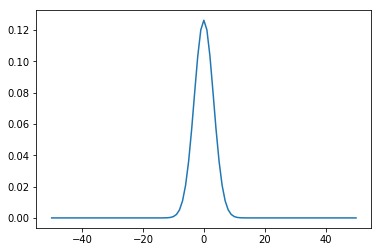

In [4]:
# definimos palabras únicas del texto
words_unique = sorted(set(libro_words))
indices = dict()
largo_ventana=100 # largo de la vetnana(nro de palabras) donde se va a convolucionar la función del kernell con la 
                  # aparición de una dada palabra en el texto para obtener la tasa de aparición de esa palabra.
vec_1=np.zeros(len(libro_words)-largo_ventana)
kern_x=list(range(int(-largo_ventana/2),int(largo_ventana/2)+1)) # enteros donde se evalúa la función del kernell
sigma_param=10 # parámetro de la función utilizada para convolucionar
kern_y=(np.exp(-np.square(kern_x)/(2*sigma_param)))/np.sqrt(2*np.pi*sigma_param) # función utilizada para la 
                                                                                 #  convolución(kernell)
plt.plot(kern_x,kern_y) # ploteamos función del kernell
tmp_occ=np.zeros(len(libro_words))

largos=dict()
for word in words_unique:
    largos[word]=libro_words.count(word) #cantidad de veces que aparece cada palabra en el texto

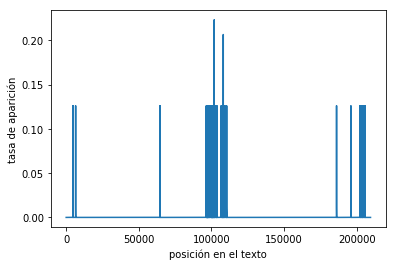

In [19]:
# calculamos tasa de aparición durante el texto para una palabra dada
word='instinct'
indices[word] = [i for i, x in enumerate(libro_words) if x == word]
tmp_occ[0:len(libro_words)]=0
tmp_occ[indices[word]]=1
for i in range(int(largo_ventana/2),int(len(libro_words)-largo_ventana/2)):
    vec_1[int(i-largo_ventana/2)]=np.sum(tmp_occ[i+np.array(kern_x)]*kern_y) # convolución del kernell con la 
                                                                             # aparición de las palabras en el texto
        
plt.plot(vec_1)
plt.xlabel('posición en el texto')
plt.ylabel('tasa de aparición')

Definimos función para calcular la autocorrelación:

In [6]:
def estimated_autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

Calculamos la correlación para la densidad de ocurrencia de la palabra calculada anteriormente:

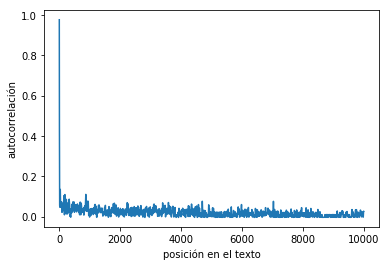

In [18]:
time=range(1,10000)
y=estimated_autocorrelation(vec_1)
plt.plot(time,y[time])
plt.xlabel('posición en el texto')
plt.ylabel('autocorrelación')

Definimos diccionario con las palabras utilizadas ordenadas por cantidad de veces de aparición. Seleccionamos 100 palabras que sean representativas de las frecuencias de aparición de las palabras del texto.

In [9]:
largos_ord=OrderedDict(sorted(largos.items(), key=lambda t: t[1]))
largos_ord[list(largos_ord)[10162]]
len(largos_ord)
maximo=len(largos_ord)-1
refs= [None] * 100
for i in range(1,101):
    refs[i-1]=list(largos_ord)[int(maximo/100*i)]

Partimos el texto en 64 partes con canitdad de palabras iguales en cada parte y luego calculamos la entropía para cada una de estas 100 palabras.

In [10]:
# partimos el texto en 64 partes 
P=64
part=dict()
for p in range(1,P):
    part[p]=libro_words[int((p-1)*len(libro_words)/P):int((p)*len(libro_words)/P)]
entr=dict()

# calculamos la entropía para cada una de estas 100 palabras 
for word in refs:
    N=largos[word]
    s=0
    for j in range (1,64):
        nj=part[j].count(word)
        s=s + -(nj/N)*np.log2(0.0000001+nj/N)
    entr[word]=s
    
print(entr)

{'descent': 4.1911580935382, 'spanish': 1.5849620679127088, 'influence': 3.6537546885156358, 'prise': -1.4426949695965583e-07, 'rafinesque': -1.4426949695965583e-07, 'roots': 1.8423704160992354, 'either': 5.4230435711044658, 'umbelliferous': -1.4426949695965583e-07, 'probosciformed': -1.4426949695965583e-07, 'valuations': -1.4426949695965583e-07, 'conduisent': -1.4426949695965583e-07, 'answered': 2.3219273735400221, 'pushed': 0.91829554551551384, 'range': 4.0657674219872302, 'spots': 1.4999995671915598, 'monuments': 1.5849620679127088, 'institution': -1.4426949695965583e-07, 'elephants': 1.5849620679127088, 'ornithologist': -1.4426949695965583e-07, 'the': 5.9014005367245286, 'division': 3.4117499782730856, 'creative': 1.3709501616462407, 'flight': 3.6467961324753384, 'hippopotamus': -1.4426949695965583e-07, 'bonin': -1.4426949695965583e-07, 'schlegel': 0.99999971146102085, 'touch': 1.8799642273798631, 'philosophy': 1.5849620679127088, 'naturally': 4.7045074201757551, 'otter': 0.9999997

Calculamos la entropía para cada una de estas 100 palabras, pero ahora randomizando el orden de las palabras en el texto original.

In [11]:
# creamos texto randomizado
libro_words_shuffled=rnd.sample(libro_words,len(libro_words))

# partimos texto en 64 partes 
part_s=dict()
for p in range(1,P):
    part_s[p]=libro_words_shuffled[int((p-1)*len(libro_words_shuffled)/P):int((p)*len(libro_words_shuffled)/P)]
entr_s=dict()

# calculamos la entropía para cada una de estas 100 palabras 
for word in refs:
    N=largos[word]
    s=0
    for j in range (1,64):
        nj=part_s[j].count(word)
        s=s + -(nj/N)*np.log2(0.0000001+nj/N)
    entr_s[word]=s
    
print(entr_s)

{'descent': 5.3217054181139467, 'spanish': 0.91829554551551384, 'influence': 3.916124638278264, 'prise': -1.4426949695965583e-07, 'rafinesque': -1.4426949695965583e-07, 'roots': 2.807353912171429, 'either': 5.3477767355502932, 'umbelliferous': -1.4426949695965583e-07, 'probosciformed': -1.4426949695965583e-07, 'valuations': -1.4426949695965583e-07, 'conduisent': -1.4426949695965583e-07, 'answered': 2.3219273735400221, 'pushed': 1.5849620679127088, 'range': 5.0305005989872438, 'spots': 1.999999422922099, 'monuments': 1.5849620679127088, 'institution': -1.4426949695965583e-07, 'elephants': 1.5849620679127088, 'ornithologist': 0.99999971146102085, 'the': 5.904460879219358, 'division': 4.3565551614914471, 'creative': 2.3219273735400221, 'flight': 4.3491967654242405, 'hippopotamus': -1.4426949695965583e-07, 'bonin': -1.4426949695965583e-07, 'schlegel': 0.49999985573051042, 'touch': 2.947701625064544, 'philosophy': 1.5849620679127088, 'naturally': 4.6489520088893137, 'otter': 0.9999997114610

Armamos las variables para comparar ambas entropías calculadas, y ploteamos las mismas

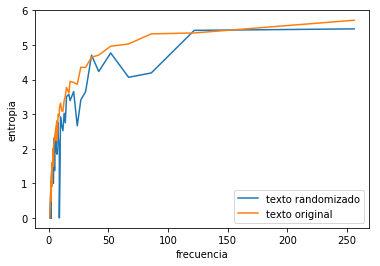

In [12]:
i = -1
x = np.zeros(len(refs))
y_s = np.zeros(len(refs))
y = np.zeros(len(refs))
for word in refs:
    i = i+1
    x[i] = largos[word]
    y[i] = entr[word]
    y_s[i] = entr_s[word]
    
plt.plot(x[1:99],y[1:99], label='texto randomizado')
plt.xlabel('frecuencia')
plt.ylabel('entropia')
plt.plot(x[1:99],y_s[1:99], label='texto original')
plt.legend()

## Parte 3: Word embeddings, distancia semántica y Word-Net

Entrenamos el modelo de LSA utilzando el corpus de noticias AP:

In [35]:
# creamos lista con el corpus de noticias de ap
n = news.transpose()
news_list = [n.iloc[0].values[0]]

for i in range(1, n.shape[0]):
   snip = n.iloc[i].values[0]
   news_list.append(snip)

# sacamos signos de puntuacion
news2 = [document.translate(str.maketrans('','',string.punctuation))for document in news_list]
news2 = [document.translate(str.maketrans('','','1234567890'))for document in news2]

# removemos palabras comunes y tokenizamos
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in news2]

# removemos palabras que solo aparecen una vez en el texto
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

#from pprint import pprint  # pretty-printer
#pprint(texts)

# creamos diccionario
dictionary = corpora.Dictionary(texts)
dictionary.save('/home/martinagv/Documents/CienciaDatos/cdd/tp6/ap/ap_dict')  # store the dictionary, for future reference

# creamos corpus en .mm
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('/home/martinagv/Documents/CienciaDatos/cdd/tp6/ap/ap.mm', corpus)  # store to disk, for later use

# entrenamos LSA
#dictionary = corpora.Dictionary.load('/home/martinagv/Documents/CienciaDatos/cdd/tp6/ap/ap_dict')
#corpus = corpora.MmCorpus('/home/martinagv/Documents/CienciaDatos/cdd/tp6/ap/ap.mm')
lsi = LsiModel(corpus, id2word=dictionary, num_topics=300)
lsi.save('/home/martinagv/Documents/CienciaDatos/cdd/tp6/lsi.lsi')


Cargamos los vectores pre-entrenados de Word2Vec:

In [ ]:
filename = '/home/martinagv/Documents/CienciaDatos/cdd/tp6/word2vec/GoogleNews-vectors-negative300.bin'
w2v = KeyedVectors.load_word2vec_format(filename, binary=True)

Computamos la similaridad entre los pares de palabras definidos en el .txt de WordSim, utilizando diferentes medidadas (WordSim, LSA, Word2Vec, path_similarity de WordNet y wup de WordNet):

In [ ]:
# abrimos el .txt de WordSim353
wordsim = open('/home/martinagv/Documents/CienciaDatos/cdd/tp6/wordsim353_sim_rel/wordsim_similarity_goldstandard.txt').read()

# tokenizamos el documento
wordsim_tokenize = tokenize.word_tokenize(wordsim)

# pasamos la lista a formato array
lista = np.array(wordsim_tokenize)

# creamos indices
t = int(len(lista) / 3)
idx = np.array(range(0, t))
idx = (idx + 1) * 3 - 1

# creamos lista de coeficientes
coef = lista[idx]

# creamos lista de pares
word1 = lista[idx - 2]
word2 = lista[idx - 1]
pares = np.vstack([word1, word2])

# creamos funcion para calcular similaridad entre palabras con lsa
def wordsim(word1, word2, target_dictionary, target_lsi_model):
    # look up each word in the LSA/LSI model of choice
    vec_bow1 = target_dictionary.doc2bow([word1])
    vec_bow2 = target_dictionary.doc2bow([word2])

    # make sure both words are actually in the topic space
    if len(vec_bow1) > 0 and len(vec_bow2) > 0:

        # if they are, go ahead and find their values in the "num_topic"-dimensional space created from gensim.models.LsiModel
        vec_lsi1 = pd.DataFrame(target_lsi_model[vec_bow1], columns=['dim', 'val'])
        vec_lsi2 = pd.DataFrame(target_lsi_model[vec_bow2], columns=['dim', 'val'])
        return -1 * scipy.spatial.distance.cosine(vec_lsi1['val'], vec_lsi2['val']) + 1  # snippet from Rick Dale

    # if the word isn't in the topic space, kick back an error
    else:
        return 'NaN'
    
# creamos listas vacias
wordsim_c = np.ndarray((pares.shape[1], 1))
w2v_c = np.ndarray((pares.shape[1], 1))
lsa_c = np.ndarray((pares.shape[1], 1))
wn_path_c = np.ndarray((pares.shape[1], 1))
wn_lch_c = np.ndarray((pares.shape[1], 1))
wn_wup_c = np.ndarray((pares.shape[1], 1))

# computamos la similaridad entre los pares de palabras con las diferentes medidas
for i in range(0, pares.shape[1]):
    w1 = pares[0, i]
    w2 = pares[1, i]
    wordsim_c[i] = coef[i] # similaridad con wordsim
    w2v_c[i] = w2v.wv.similarity(w1,w2) # similaridad con word2vec
    lsa_c[i] = wordsim(w1, w2, dictionary, lsi) # similaridad con lsa
    w1_2 = wn.synsets(w1)[0]
    w2_2 = wn.synsets(w2)[0]
    wn_path_c[i] = w1_2.path_similarity(w2_2) # similaridad con la medida path_similarity de Wordnet
    wn_wup_c[i] = w1_2.wup_similarity(w2_2) # similaridad con la medida wup de Wordnet

# guardamos los arrays de similaridad
np.save('/home/martinagv/Documents/CienciaDatos/cdd/tp6/wordsim_c.npy', wordsim_c)
np.save('/home/martinagv/Documents/CienciaDatos/cdd/tp6/w2v_c.npy', w2v_c)
np.save('/home/martinagv/Documents/CienciaDatos/cdd/tp6/lsa_c.npy', lsa_c)
np.save('/home/martinagv/Documents/CienciaDatos/cdd/tp6/wn_path_c.npy', wn_path_c)
np.save('/home/martinagv/Documents/CienciaDatos/cdd/tp6/wn_wup_c.npy', wn_wup_c)

Computamos la correlación entre los índices de similaridad de WordSim y Word2Vec:

Correlation between WordSim and Word2Vec: 0.771723927695(r), 2.2385731613139787e-41(p-value)


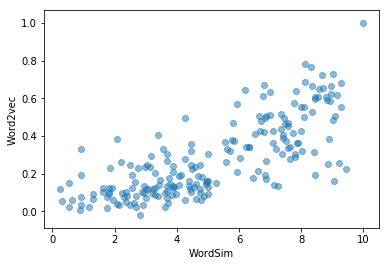

In [13]:
# cargamos los arrays de similaridad 
wordsim_c = np.load('/home/martinagv/Documents/CienciaDatos/cdd/tp6/wordsim_c.npy')
w2v_c = np.load('/home/martinagv/Documents/CienciaDatos/cdd/tp6/w2v_c.npy')
lsa_c = np.load('/home/martinagv/Documents/CienciaDatos/cdd/tp6/lsa_c.npy')
wn_path_c = np.load('/home/martinagv/Documents/CienciaDatos/cdd/tp6/wn_path_c.npy')
wn_wup_c = np.load('/home/martinagv/Documents/CienciaDatos/cdd/tp6/wn_wup_c.npy')

# computamos la correlacion entre wordsim y word2vec
corr1 = scipy.stats.mstats.spearmanr(wordsim_c, w2v_c)
print('Correlation between WordSim and Word2Vec: ' + str(corr1[0]) + '(r), ' + str(corr1[1].data) + '(p-value)')
plt.scatter(wordsim_c, w2v_c, alpha=0.5) # ploteamos un scatter para evaluar la relación
plt.xlabel('WordSim')
plt.ylabel('Word2vec')

Hacemos lo mismo para los índices de similaridad de WordSim y LSA: 

Correlation between WordSim and LSA: 0.302420679689(r), 1.157996153651915e-05(p-value)


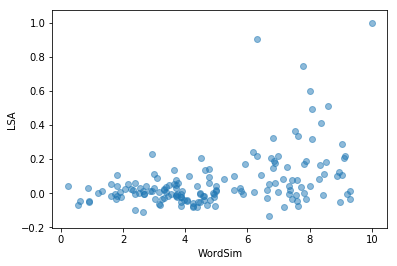

In [14]:
# computamos la correlacion entre wordsim y lsa
corr2 = scipy.stats.mstats.spearmanr(wordsim_c, lsa_c)
print('Correlation between WordSim and LSA: ' + str(corr2[0]) + '(r), ' + str(corr2[1].data) + '(p-value)')
plt.scatter(wordsim_c, lsa_c, alpha=0.5) # ploteamos un scatter para evaluar la relación
plt.xlabel('WordSim')
plt.ylabel('LSA')

Como observamos, las medidas de similardidad de WordSim y Word2Vec se encuentran más correlacionadas que las medidas de WordSim y LSA. Sin embargo, esto puede deberse a que el corpus de entrenamiento de LSA fue de menor tamaño y diferente al de Word2Vec. Vemos además que los índices de similaridad de LSA son bajos en su mayoría. Para estimar con más certeza la correlación deberíamos de haber entrenado a ambos modelos con el mismo corpus. Esto no fue posible porque el corpus de Google News no se encuentra disponible (y de estarlo se necesita mucho tiempo de cómputo para entrenar al modelo). 

Luego computamos la correlación entre los índices de similaridad de WordNet y Word2Vec: 

Correlation between WordNet(path_similarity) and Word2Vec: 0.426519668771(r), 2.2220146710972834e-10(p-value)


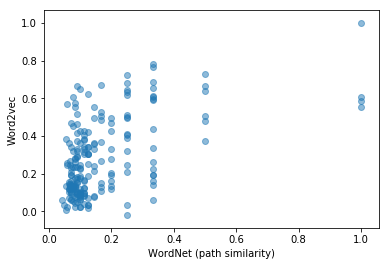

Correlation between WordNet(wup)and Word2Vec: 0.508067134715(r), 1.013324370005006e-14(p-value)


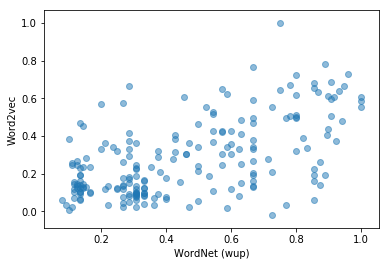

In [15]:
# computamos la correlacion entre path_similarity de wordnet y word2vec
corr3 = scipy.stats.mstats.spearmanr(wn_path_c, w2v_c)
print('Correlation between WordNet(path_similarity) and Word2Vec: ' + str(corr3[0]) + '(r), ' + str(corr3[1].data) + '(p-value)')
plt.scatter(wn_path_c, w2v_c, alpha=0.5) # ploteamos un scatter para evaluar la relación
plt.xlabel('WordNet (path similarity)')
plt.ylabel('Word2vec')
plt.show()

# computamos la correlacion entre wup de wordnet y word2vec
corr4 = scipy.stats.mstats.spearmanr(wn_wup_c, w2v_c)
print('Correlation between WordNet(wup)and Word2Vec: ' + str(corr4[0]) + '(r), ' + str(corr4[1].data) + '(p-value)')
plt.scatter(wn_wup_c, w2v_c, alpha=0.5) # ploteamos un scatter para evaluar la relación
plt.xlabel('WordNet (wup)')
plt.ylabel('Word2vec')

Hacemos lo mismo para los índices de similaridad de WordNet y LSA: 

Correlation between WordNet(path_similarity) and LSA: 0.22009587829(r), 0.00160332132623896(p-value)


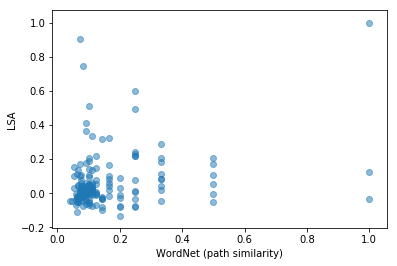

Correlation between WordNet(wup)and LSA: 0.260152319948(r), 0.00017792323837884303(p-value)


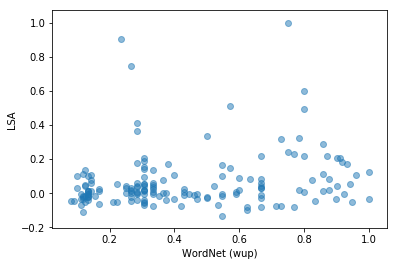

In [16]:
# computamos la correlacion entre path_similarity de wordnet y LSA
corr5 = scipy.stats.mstats.spearmanr(wn_path_c, lsa_c)
print('Correlation between WordNet(path_similarity) and LSA: ' + str(corr5[0]) + '(r), ' + str(corr5[1].data) + '(p-value)')
plt.scatter(wn_path_c, lsa_c, alpha=0.5) # ploteamos un scatter para evaluar la relación
plt.xlabel('WordNet (path similarity)')
plt.ylabel('LSA')
plt.show()

# computamos la correlacion entre wup de wordnet y LSA
corr6 = scipy.stats.mstats.spearmanr(wn_wup_c, lsa_c)
print('Correlation between WordNet(wup)and LSA: ' + str(corr6[0]) + '(r), ' + str(corr6[1].data) + '(p-value)')
plt.scatter(wn_wup_c, lsa_c, alpha=0.5) # ploteamos un scatter para evaluar la relación
plt.xlabel('WordNet (wup)')
plt.ylabel('LSA')

De manera similar al punto anterior, encontramos que las medidas de WordNet y las de Word2Vec se encuentran más correlacionadas que las medidas de WordNet y LSA. 